### This notebook expands on Poisson spike train methods. From class exercise on 22 September 2025.

In [21]:
# Read in libraries
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Let's update our Poission spike train generators with refractory periods. 

In other words, we need to ensure that a spike only occurs after $\tau_{ref}$ has elapsed.

For Method 1, one strategy is find spikes that occur in all bins, then filter those that are less than $\tau_{ref}$ apart.

In [22]:
def poisson_refractory_method1(rate, T, dt=1e-4, tau_ref=0.05, rng=None):
    """
    Generate Poisson spike train of length T, rate rate, and refractory period.

    Parameters
    ----------
    rate : float
        Expected firing rate of the spike train
    T : float
        Length of time for spike train (seconds)
    dt : float
        (optional) Small dt to determine binning of spike train
    tau_ref : float
        (optional) Refractory period, shortest time between spikes
    rng : numpy.random.Generator, optional
        Defaults to None, otherwise sets random seed

    Returns
    --------
    np.ndarray
        array of spike times following poisson distribution
    """
    rng = np.random.default_rng(rng)  # set random seed
    n_bins = int(T / dt)  # determine total bins
    prob = rate * dt  # probability of a spike
    spikes = rng.random(n_bins) < prob  # check if spike occurs in time bin
    times = (np.arange(n_bins) + 0.5) * dt  # create time array corresponding to bins

    final_spike_train = []
    last_spike = -1

    # Iterate through all spikes only add those at least tau_ref apart
    # to final spike train
    for s, t in zip(spikes, times):
        if s and (t - last_spike >= tau_ref):
            final_spike_train.append(t)
            last_spike = t
    return np.array(final_spike_train)

Method 2 is a little different. The expontential distribution is no longer $1/r$ but $1/r-\tau_{ref}$.
Then we need to add back in the time for the next spike, with $\tau_{ref}$. 

Spikes occur at: $t + \Delta t + \tau_{ref}$. One caveat, the rate must be smaller than $1/\tau_{ref}$ so that the exponential distribution does not have a negative input. 

In [23]:
def poisson_refractory_method2(rate, T, tau_ref=0.05, rng=None):
    """
    Generate Poisson spike train of length T, rate rate, and refractory period.

    Parameters
    ----------
    rate : float
        Expected firing rate of the spike train
    T : float
        Length of time for spike train (seconds)
    tau_ref : float
        (optional) Refractory period, shortest time between spikes
    rng : numpy.random.Generator, optional
        Defaults to None, otherwise sets random seed

    Returns
    --------
    np.ndarray
        array of spike times following poisson distribution
    """
    # set random seed
    rng = np.random.default_rng(rng)

    # Maximum possible firing rate and guard against tau_ref = 0
    r_ceil = 1 / max(tau_ref, 1e-12)

    # Enforce feasbility, rate must be < 1/tau_ref
    if rate >= 1 / max(tau_ref, 1e-12):
        raise ValueError(
            f"Requested rate {rate:.3f} Hz >= 1/tau_ref = {r_ceil:.3f} Hz. "
            "Decrease rate or tau_ref."
        )

    # Mean of exponential distribution to draw ISIs from
    r_max = max(1 / rate - tau_ref, 1e-12)

    # Empty array to hold spike times
    spikes = []

    # Evolve time by ISIs to identify spikes
    t = 0
    while t < T:
        if t == 0:  # first spike does not need refractory
            t += rng.exponential(r_max)
        else:  # Subsequent spikes have refractory period
            t += rng.exponential(r_max) + tau_ref

        # keep spike as long smaller than cutoff T
        if t < T:
            spikes.append(t)
    return np.asarray(spikes)

Great! You now have two different methods to create Poisson spike trains.

Let's take a look at them. Run the code below to generate lists of spike trains using the two methods.

In [50]:
# set desired time
T = 1
dt = 1e-3

# refractory
tau_ref = 0.05

# Set rates for method 1 and method 2
rates_method1 = np.random.randint(10, 11, size=100)
rates_method2 = np.random.randint(10, 11, size=100)

# Using list comprehension, generate spike trains
trains_method1 = [
    poisson_refractory_method1(r, T, dt=dt, tau_ref=tau_ref) for r in rates_method1
]
trains_method2 = [
    poisson_refractory_method2(r, T, tau_ref=tau_ref) + T for r in rates_method2
]

Finally, run the code below. `eventplot` is a nice built-in function from `matplotlib` that shows timing of discrete events.

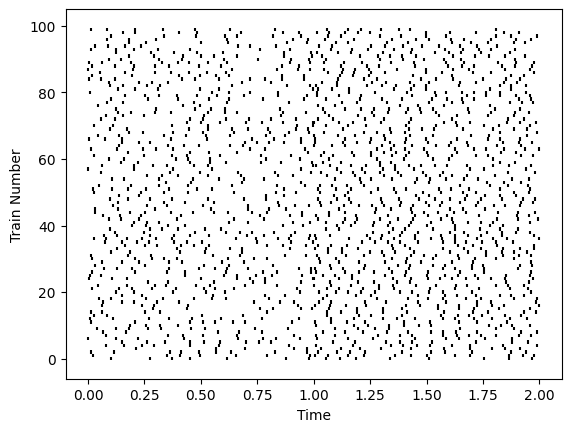

In [51]:
plt.eventplot(trains_method1, color="k")
plt.eventplot(trains_method2, color="k")
plt.xlabel("Time")
plt.ylabel("Train Number")
plt.show()

Great, we've adapted the Poisson spike train generator methods to encompass a refractory period. But spike trains can have bursts as well! Let's build on these methods to allow for the probability that a burst might occur.

We want to enter a burst with some probability, and exit with some probability. When in a burst, the firing rate should be much higher than the background spike train. Similar to a refractory period of a spike, we can include a refractory period of a burst.

Read through function below that adapts Method 1. Remember, the probabilities are multiplied by `dt`, this is why the default values are higher than 1. 


In [26]:
def poisson_burst_method1(
    rate,
    burst_rate,
    T,
    dt=1e-3,
    tau_ref=0.05,
    tau_burst=0.1,
    prob_burst=1,
    prob_end=30,
    rng=None,
):
    """
    Generate Poisson spike train of length T, rate rate, and refractory period.
    There is a chance of bursting at rate burst_rate.

    Parameters
    ----------
    rate : float
        Baseline firing rate of the spike train
    burst_rate : float
        Elevated firing rate used during a burst
    T : float
        Length of time for spike train (seconds)
    dt : float
        (optional) Small dt to determine binning of spike train
    tau_ref : float
        (optional) Refractory period, shortest time between spikes
    tau_burst : float
        (optional) Minimum time between consecutive bursts
    prob_burst : float
        (optional) Per-second hazard to start a burst (converted to per-bin as prob_burst*dt)
    prob_end : float
        (optional) Per-second hazard to end a burst (converted to per-bin as prob_end*dt)
    rng : numpy.random.Generator, optional
        Defaults to None, otherwise sets random seed

    Returns
    --------
    np.ndarray
        array of spike times following poisson distribution
    """
    # set random seed
    rng = np.random.default_rng(rng)

    # Empty array to hold spikes
    spikes = []
    t = 0.0

    # boolean to track if we are in a burst
    in_burst = False

    # Checks for most recent spike time, and most recent burst spike
    last_spike = -1
    last_burst = -1

    # Evolve time by dt to find spike times
    while t < T:

        # If not in burst, see if we enter burst, assuming time since the
        # last spike of the most recent burst is larger than tau_burst
        if not in_burst and t - tau_burst >= last_burst:
            if rng.random() < prob_burst * dt:
                in_burst = True

        # If in burst, see if we need to exit burst
        elif in_burst and rng.random() < prob_end * dt:
            in_burst = False

        # Determine rate for see if spike occurred, different if in burst or not
        rate_check = burst_rate if in_burst else rate

        # Determine if we spiked in the bin, assuming tau_ref has elapsed
        if rng.random() < rate_check * dt and t - tau_ref >= last_spike:
            spikes.append(t)
            last_spike = t

            # Update last spike in burst
            if in_burst:
                last_burst = t

        # Advance time by one step
        t += dt
    return np.array(spikes)

What about method 2? We can augment that method as well. Here the probabilites are below one because we are not checking every time bin. In `poisson_refractory_method2` above there was a check for feasibility, comparing rate to $1/\tau_{ref}$. This still needs to occur, but we need to check that the burst rate passes this check as well.

Read through function below that adapts Method 2.

In [27]:
def poisson_burst_method2(
    rate,
    burst_rate,
    T,
    tau_ref=0.05,
    tau_burst=0.1,
    prob_burst=0.2,
    prob_end=0.5,
    rng=None,
):
    """
    Generate Poisson spike train of length T, rate rate, and refractory period.
    There is a chance of bursting at rate burst_rate

    Parameters
    ----------
    rate : float
        Baseline firing rate of the spike train
    burst_rate : float
        Elevated firing rate used during a burst
    T : float
        Length of time for spike train (seconds)
    dt : float
        (optional) Small dt to determine binning of spike train
    tau_ref : float
        (optional) Refractory period, shortest time between spikes
    tau_burst : float
        (optional) Minimum time between consecutive bursts
    prob_burst : float
        (optional) Probability to enter a burst.
    prob_end : float
        (optional) Probability to end the burst.
    rng : numpy.random.Generator, optional
        Defaults to None, otherwise sets random seed

    Returns
    --------
    np.ndarray
        array of spike times following poisson distribution
    """

    # Set random seed
    rng = np.random.default_rng(rng)

    # Maximum possible firing rate and guard against tau_ref = 0
    r_ceil = 1 / max(tau_ref, 1e-12)

    # Enforce feasbility, rate must be < 1/tau_ref
    if rate >= 1 / max(tau_ref, 1e-12):
        raise ValueError(
            f"Requested rate {rate:.3f} Hz >= 1/tau_ref = {r_ceil:.3f} Hz. Decrease rate or tau_ref."
        )
    if burst_rate > r_ceil:
        raise ValueError(
            f"Requested burst rate {burst_rate:.3f} Hz > 1/tau_ref = {r_ceil:.3f} Hz. Decrease burst rate or tau_ref"
        )

    # Empty array to hold spike times
    spikes = []
    t = 0

    # bool for in burst
    in_burst = False

    # time of last spike in burst
    last_burst = -1

    # Loop through time and draw ISIs
    while t < T:

        # Enter burst if prob_burst met and time since last_burst is greater than tau_burst
        if rng.random() < prob_burst and (t - last_burst) >= tau_burst:
            in_burst = True

            # In the burst, update spike times
            while in_burst and t < T:

                # Draw ISIs from burst_rate distribution and include tau_ref
                t += rng.exponential(1 / burst_rate - tau_ref) + tau_ref

                # Only add spike if smaller than cutoff time
                if t < T:
                    spikes.append(t)

                # Check if probability met to end the burst
                # Record exiting burst and last spike in burst
                if rng.random() < prob_end:
                    in_burst = False
                    last_burst = t
        else:
            # Draw ISI from background rate if not in burst
            t += rng.exponential(1 / rate - tau_ref) + tau_ref

            # Only add spike if smaller than cutoff time
            if t < T:
                spikes.append(t)
    return np.array(spikes)

Now that these methods are implemented, we can try them out. 

Below we create spike trains of a given rate. Here, just 10 Hz for all spike trains. Read through the comments to see how we make the parameters of the two methods equal.

Is there still some variation in the spike trains? Why do you think that is?

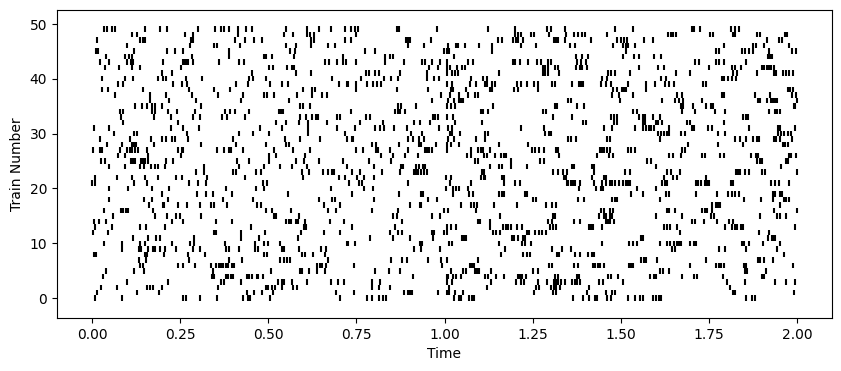

In [ ]:
# set desired time and time step
T = 1
dt = 1e-3

# refractory parameters
tau_ref = 0.005
tau_burst = 0.01

# Set rates for method 1 and method 2
rates_method1 = np.random.randint(10, 11, size=50)
rates_method2 = np.random.randint(10, 11, size=50)

# If we wanted to match the proabilities of bursting, we need to account for how these are used.
# To make these equal we need to set:
# prob_burst_method1 ~ prob_burst_method2 * rate
# prob_exit_method1 ~ prob_exit_method2 * rate_burst

# Set probability for method 2
prob_burst_method2 = 0.5
prob_exit_method2 = 0.5

# Set probability for method 1 (remember this is prob*dt)
prob_burst_method1 = 5  # set as average rate * prob_burst_method2 for matching
prob_exit_method1 = 50  # set as average burst_rate * prob_exit_method2 for matching

# Using list comprehension, generate spike trains
trains_method1 = [
    poisson_burst_method1(
        r,  # rate
        10 * r,  # burst rate
        T,  # cut off time
        dt=dt,  # size of time bins
        tau_ref=tau_ref,  # spike refractory period
        tau_burst=tau_burst,  # burst refractory period
        prob_burst=prob_burst_method1,  # proability of enteringa burst (used as prob_burst*dt)
        prob_end=prob_exit_method1,  # probability of exiting a burst (used as prob_end*exit)
    )
    for r in rates_method1
]
trains_method2 = [
    poisson_burst_method2(
        r,  # rate
        10 * r,  # burst rate
        T,  # cut off time
        tau_ref=tau_ref,  # spike refractory period
        tau_burst=tau_burst,  # burst refractory period
        prob_burst=prob_burst_method2,  # proability of enteringa burst
        prob_end=prob_exit_method2,  # probability of exiting a burst
    )
    + T
    for r in rates_method2
]

# plot generated spike trains
# method 1 is from 0 to T
# Method 2 is from T to 2*T
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.eventplot(trains_method1, color="k")
ax.eventplot(trains_method2, color="k")
ax.set_xlabel("Time")
ax.set_ylabel("Train Number")
plt.show()

How can we better understand the changing firing rates as population? 

We can use the peri-stimulus time histogram, PSTH. This is a histogram of firing rates over time, averaged for a population.

In [ ]:
def psth(spikes, bin_size, T0, T1):
    """
    Computes peri-stimulus time histogram from multiple spike trains.

    Parameters
    ----------
    spikes : list of np.ndarray
        List where each element is 1d array of spike times between T0 and T1
    bin_size : float
        Width of each bin for the histogram
    T0 : float
        Start time of the analysis window
    T1 : float
        End time of the analysis window.

    Returns
    -------
    bin_centers : np.ndarray
        1d array of time points representing centers of bins for histogram
    counts : np.ndarray
        1d array of average firing rates across all trials aligned at bin_centers
    """

    # Create bin edges from T0 to T1 by bin_size
    bin_edges = np.arange(T0, T1 + bin_size, bin_size)

    # Empty array to hold all spike counts
    counts = np.zeros(len(bin_edges) - 1)

    # Loop through spike trains in spikes list
    # Determine histogram for each spike train and update counts
    for spks in spikes:
        hist_counts, _ = np.histogram(spks, bins=bin_edges)
        counts += hist_counts

    # Divide counts by bin_size and number of trials to return firing rate
    counts = counts / (bin_size * len(spikes))

    # Determine bin_centers for better plotting
    bin_centers = bin_edges[:-1] + bin_size / 2

    return bin_centers, counts

Now let's apply this to the spike trains we generated with the two Poisson methods above.

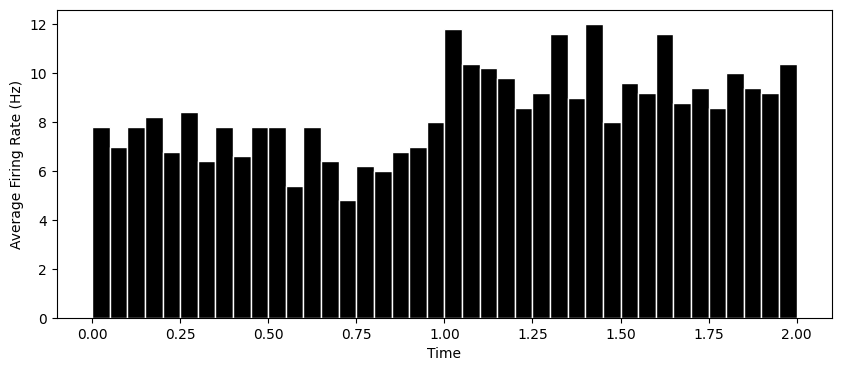

In [ ]:
# collect spike trains in a format for PSTH
all_spikes = [
    np.concatenate([trains_method1[i], trains_method2[i]])
    for i in range(len(trains_method1))
]

# Set parameters for PSTH
T0 = 0
T1 = 2
bin_size = 0.050  # try different values of bin_size, how does this change the PSTH?

# Calculate PSTH
bcs, psth_fig = psth(all_spikes, bin_size, T0, T1)

# Plot PSTH
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.bar(bcs, psth_fig, width=bin_size, color="k", edgecolor="w")
ax.set_xlabel("Time")
ax.set_ylabel("Average Firing Rate (Hz)")
plt.show()

Another way we can visualize the temporal structure of a spike train is the autocorrelogram (ACG).

This shows the probability of a spike at a particular lag relative to another spike. 
* In the function below, values are normalized such that if the heights are around 1, the spike train is roughly Poisson. 
* If there is a large dip at 0 below 1, then that is indicative common ISI values between spikes. Possibly indicating refractory period.
* If there is a large increase at 0 above 1, then smaller values further away from 0, then this indicates possible bursting behavior - a mix of small and large ISIs.

We won't use ACG all that much in this course, but it is a common tool reported in computational neuroscience papers.

In [ ]:
def autocorrelogram(spikes, T, max_lag=0.02, bin_size=0.005):
    """
    Computer the spike trian autocorrelogram (ACG). This shows probability of
    finding a spike at a time lag relative of another spike. Elucidates
    temporal properties of spike train.

    Parameters
    ----------
    spikes : array_like
        1D array of sorted spike times
    T : float
        Total duration of spike train
    max_lag : float
        (optional) Maximum time lag to consider
    bin_size : float
        (optioal) Bin width for histogram of spike differences

    Returns
    -------
    bin_centers : np.ndarray
        1d array of time points representing centers of bins for histogram
    acorr : np.ndarray
        Normalized autocorrelogram values, units are spike density.
    """

    # Empty array to hold spike differences
    diffs = []

    # Change list to numpy array
    spikes = np.asarray(spikes)

    # Iterate thorugh all spike times
    for i in range(len(spikes)):

        # Determine lags to all later spikes
        lags = spikes[i + 1 :] - spikes[i]

        # Keep lags above some threshold and remove above max_lag
        lags = lags[(np.abs(lags) >= 1e-12) & (np.abs(lags) <= max_lag)]
        diffs.append(lags)

    # Flatten list into one large array
    diffs = np.concatenate(diffs) if len(diffs) > 0 else np.array([])

    # Default to symmetric ACG, provide negative lags
    diffs = np.concatenate([diffs, -diffs])

    # Define bins and bins centers as determined by max_lag
    bin_edges = np.arange(-max_lag, max_lag + bin_size, bin_size)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    # Calculate the ACG by bins
    acorr, _ = np.histogram(diffs, bins=bin_edges)

    # Determine rate of spike train
    rate = len(spikes) / T

    # Normalize histogram for better comparison across datasets
    edge = np.maximum(1e-12, T - np.abs(bin_centers))
    acorr = acorr / (rate**2 * (edge * bin_size))
    return bin_centers, acorr


def cv(spikes):
    """
    Computer coefficient of variation (CV) of a spike train.

    Parameters
    ----------
    spikes : array_like
        1D array of sorted spike times

    Returns
    -------
    float
        Coefficient of variation of ISIs
    """
    # Compute ISIs
    diff = np.diff(spikes)

    # Calculate and return CV
    return np.std(diff) / np.mean(diff)

Lets try it out! The code below constructs a spike train using method 1 with certain desired properties. Then plots the ACG.

For ACGs it is common to use longer spike trains. Let's look at spike train that is Poisson-like.

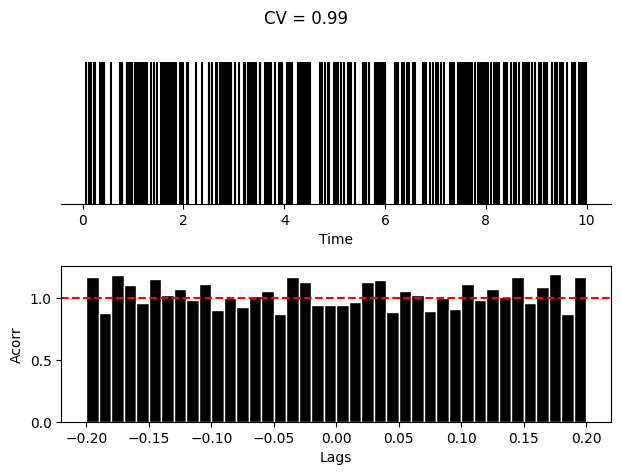

In [70]:
T = 10  # Spike train length
max_lag = 0.2  # max_lag
bin_size = 0.01  # bin_size (10 ms)

# Construct the spike train
rate = 30
burst_rate = 0
tau_ref = 0.00
tau_burst = 0.0
prob_burst = 0
prob_end = 0
spikes = poisson_burst_method1(
    rate,
    burst_rate,
    T,
    tau_ref=tau_ref,
    tau_burst=tau_burst,
    prob_burst=prob_burst,
    prob_end=prob_end,
)

# Calculate the ACG
lags, acorr = autocorrelogram(spikes, T, max_lag=max_lag, bin_size=bin_size)

# Plot the ACG with the corresponding spike train
fig, ax = plt.subplots(2, 1, tight_layout=True)

# Title the figure with the CV value
plt.suptitle(f"CV = {cv(spikes):.02f}")

ax[0].eventplot(spikes, color="k")
ax[1].bar(lags, acorr, width=bin_size, edgecolor="w", color="k", align="center")
ax[1].axhline(1, color="r", ls="--")
ax[1].set_xlabel("Lags")
ax[1].set_ylabel("Acorr")
ax[0].set_ylim([0.5, 1.6])
ax[0].set_xlabel("Time")
ax[0].spines[["top", "left", "right"]].set_visible(False)
ax[0].set_yticks([])
plt.show()

Now let's look at spike train that is fairly regular, or tonic.

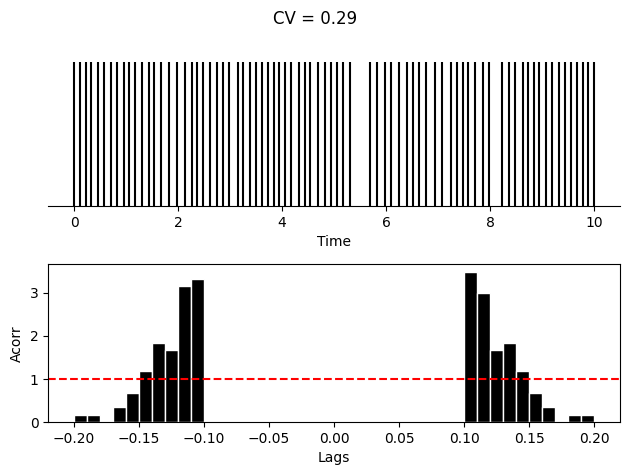

In [67]:
T = 10  # Spike train length
max_lag = 0.2  # max_lag
bin_size = 0.01  # bin_size (10 ms)

# Construct the spike train
rate = 30
burst_rate = 0
tau_ref = 0.1
tau_burst = 0.00
prob_burst = 0
prob_end = 0
spikes = poisson_burst_method1(
    rate,
    burst_rate,
    T,
    tau_ref=tau_ref,
    tau_burst=tau_burst,
    prob_burst=prob_burst,
    prob_end=prob_end,
)

# Calculate the ACG
lags, acorr = autocorrelogram(spikes, T, max_lag=max_lag, bin_size=bin_size)

# Plot the ACG with the corresponding spike train
fig, ax = plt.subplots(2, 1, tight_layout=True)

# Title the figure with the CV value
plt.suptitle(f"CV = {cv(spikes):.02f}")

ax[0].eventplot(spikes, color="k")
ax[1].bar(lags, acorr, width=bin_size, edgecolor="w", color="k", align="center")
ax[1].axhline(1, color="r", ls="--")
ax[1].set_xlabel("Lags")
ax[1].set_ylabel("Acorr")
ax[0].set_ylim([0.5, 1.6])
ax[0].set_xlabel("Time")
ax[0].spines[["top", "left", "right"]].set_visible(False)
ax[0].set_yticks([])
plt.show()

Finally, let's look at the ACG for a highly bursty neuron.

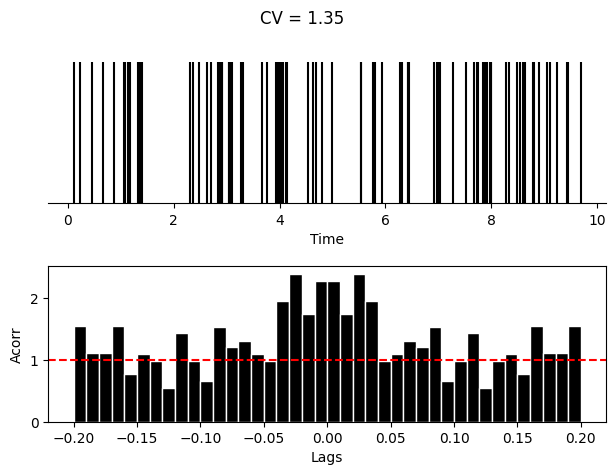

In [68]:
T = 10  # Spike train length
max_lag = 0.2  # max_lag
bin_size = 0.01  # bin_size (10 ms)

# Construct the spike train
rate = 5
burst_rate = 90
tau_ref = 0.003
tau_burst = 0.06
prob_burst = 2
prob_end = 20
spikes = poisson_burst_method1(
    rate,
    burst_rate,
    T,
    tau_ref=tau_ref,
    tau_burst=tau_burst,
    prob_burst=prob_burst,
    prob_end=prob_end,
)

# Calculate the ACG
lags, acorr = autocorrelogram(spikes, T, max_lag=max_lag, bin_size=bin_size)

# Plot the ACG with the corresponding spike train
fig, ax = plt.subplots(2, 1, tight_layout=True)

# Title the figure with the CV value
plt.suptitle(f"CV = {cv(spikes):.02f}")

ax[0].eventplot(spikes, color="k")
ax[1].bar(lags, acorr, width=bin_size, edgecolor="w", color="k", align="center")
ax[1].axhline(1, color="r", ls="--")
ax[1].set_xlabel("Lags")
ax[1].set_ylabel("Acorr")
ax[0].set_ylim([0.5, 1.6])
ax[0].set_xlabel("Time")
ax[0].spines[["top", "left", "right"]].set_visible(False)
ax[0].set_yticks([])
plt.show()